# Encapsulating all the above

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color=['salmon', 'skyblue', 'gold', 'gray', 'limegreen', 'darkorange', 'darkviolet', 'turquoise', 'darkblue', 'black'])

In [ ]:
def Download(years, months, list_months, token):
    # Download data for period of time selected __init__
    i2m = list(zip(months, list_months))
    for year in years:
        for month, month_name in i2m:
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

    # Download station information
    os.system(f"wget -nc https://raw.githubusercontent.com/MariaMonserratM/Capstone_bike/CP-01-files-download/estaciones/Informacio_Estacions_Bicing.csv?token={token}")
    stations = pd.read_csv(f'Informacio_Estacions_Bicing.csv?token={token}')

    # Download geojson
    os.system("wget -O barris.geojson https://raw.githubusercontent.com/martgnz/bcn-geodata/master/barris/barris.json")
    barris_df = gpd.read_file('/content/barris.geojson')

    # Join data in one dataframe
    dfs = []
    for name in [filename for filename in os.listdir() if filename.endswith(".csv") and '2023' in filename]:
        df_0 = pd.read_csv(f'/content/{name}', usecols=['station_id', 'last_reported', 'num_bikes_available', 'num_docks_available'])
        df_0 = df_0.loc[~df_0.last_reported.isna()].copy()
        df_0 = df_0.loc[~df_0.station_id.isna()].copy()
        dfs.append(df_0)

        del df_0

    df = pd.concat(dfs)

    return df, stations, barris_df

data, stations_info, barris_geo = Download(years=[2023], months=[1, 2, 3], list_months=['Gener', 'Febrer', 'Marc'], token='GHSAT0AAAAAACUIGC4P3ICDZWE6WGE5XBO2ZUBOKNQ')

In [ ]:
def preprocess_merge(data, stations):
    data_pre = data.copy()

    # Datetime transformations
    data_pre['last_reported'] = pd.to_datetime(data_pre['last_reported'], unit='s')

    # Add Datetime info
    data_pre['minute'] = data_pre['last_reported'].dt.minute
    data_pre['hour'] = data_pre['last_reported'].dt.hour
    data_pre['day'] = data_pre['last_reported'].dt.day
    data_pre['month'] = data_pre['last_reported'].dt.month
    data_pre['year'] = data_pre['last_reported'].dt.year
    data_pre['hour-time'] = data_pre.last_reported.dt.strftime('%H:%M')

    # Add more week and season info
    data_pre['day_of_week'] = data_pre['last_reported'].dt.dayofweek
    data_pre['day_of_year'] = data_pre['last_reported'].dt.dayofyear
    data_pre['n_week_year'] = data_pre['last_reported'].dt.isocalendar().week
    data_pre['season'] = data_pre['month'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))
    data_pre['is_weekend'] = data_pre['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

    # Add station info
    stations['post_code'] = [str(int(stations['post_code'][x])).zfill(5) for x in range(len(stations))]
    # Select relevant columns
    stations2merge = stations[['station_id', 'name', 'lat', 'lon', 'altitude', 'post_code', 'capacity']].copy()

    # Merge with data
    data_post = data_pre.merge(stations2merge, how='left', on='station_id')

    # Look for NaNs
    idx_nans = data_post.index[data_post.isna().sum(1) > 3]
    stations_nans = data_post.loc[idx_nans, 'station_id'].unique()
    data_post.drop(idx_nans, inplace=True)

    print('Dropped stations:', len(stations_nans))
    print('Id of dropped stations:', stations_nans)

    # Add occupacy column, bigger number means more percentage of slots available
    data_post['disponibility'] = (data_post['num_docks_available'] / data_post['capacity']).clip(upper=1)
    data_post['disponibility'].fillna(0, inplace=True)

    return data_post, stations2merge

df_processed, stations2merge = preprocess_merge(data, stations_info)

Dropped stations: 5
Id of dropped stations: [ 48 188 429 487 520]


In [ ]:
# Create a function to classify stations between full, empty patterns, and also with others as stations with no patterns
def add_stations_plotly(df, idx_stations, color_choice, fig, name, size):
    try:
        stations_df = df[df.station_id.isin(idx_stations.index)]
    except:
        stations_df = df[df.station_id.isin(idx_stations)]

    fig.add_trace(go.Scattermapbox(
        lon = stations_df['lon'],
        lat = stations_df['lat'],
        mode = 'markers',
        marker = dict(
            size = size,
            color = color_choice,
            opacity = 0.9
        ),
        text = stations_df.apply(lambda row: f"ID: {row['station_id']}<br>Nombre: {row['name']}<br>Altitud: {row['altitude']}<br>Capacity: {row['capacity']}<br>Post Code: {row['post_code']}", axis=1),
        hoverinfo = 'text',
        name = f'{name} Stations'
    ))

def get_map_stations(df, upper_threshold, lower_threshold, stations):
    df_grouped = df.groupby(['station_id', 'minute', 'hour', 'day', 'month', 'year'])[['disponibility', 'altitude', 'is_weekend']].mean().reset_index().fillna(0)

    options = df.day_of_year.nunique() * 24 * 60

    list_upper = df_grouped[df_grouped.disponibility > upper_threshold].reset_index().station_id.value_counts() / options
    list_lower = df_grouped[df_grouped.disponibility < lower_threshold].reset_index().station_id.value_counts() / options

    list_upper = list_upper[list_upper > 0.1]
    list_lower = list_lower[list_lower > 0.1]

    all_stations = df.station_id.unique()
    list_others = list(set(all_stations) - set(pd.concat([list_upper, list_lower]).index))

    # Create the plot
    figure = go.Figure()

    # Plotting the full stations
    add_stations_plotly(stations, list_lower, 'salmon', figure, 'Full', 15)
    # Plotting the empty stations
    add_stations_plotly(stations, list_upper, 'skyblue', figure, 'Empty', 15)
    # Plotting other stations
    add_stations_plotly(stations, list_others, 'gray', figure, 'Others', 10)

    # Setting the layout
    figure.update_layout(
        mapbox_style="carto-positron",
        mapbox=dict(
            center=go.layout.mapbox.Center(lat=41.412153964359554, lon=2.1657918125404927),
            zoom=11.5
        ),
        title='Stations in Barcelona',
        showlegend=True,
        legend=dict(
            itemsizing='constant',
            orientation='v'
        ),
        autosize=True,
        height=1200,
    )

    # Show the plot
    figure.show()

    return list_upper, list_lower, list_others

empty_stations, full_stations, other_stations = get_map_stations(df_processed, 0.7, 0.3, stations_info)

In [ ]:
# Visualitzation of the stations in different periods of time
def print_station_info(df, id, occu_type='full'):
    station_df = df[df.station_id == id].copy()
    altitude = station_df['altitude'].iloc[0]
    capacity =  station_df['capacity'].iloc[0]
    print(f'Station is {id}, classified as {occu_type} with:\nCapacity of {capacity}\nAltitude of {altitude}\n')


class Visualitzation():
    def __init__(self, data, stations, barris, n_month_of_year, station_ids, occu_type, day_of_week):
        self.data = data
        self.stations = stations
        self.barris = barris
        self.month_year = n_month_of_year
        self.stations_ids = station_ids
        self.occu_type = occu_type
        self.day_week = day_of_week

    def heatmap(self):
        df2plot = self.data[(self.data.month == self.month_year)].copy()

        for station_id in self.stations_ids:
            fig, ax = plt.subplots(figsize=(20, 3))

            df2plot_station = df2plot[(df2plot.station_id == station_id) & (df2plot.day_of_week == self.day_week)].copy()

            station_df = df2plot_station.groupby(['day_of_year', 'hour-time'])['disponibility'].mean().reset_index()
            station_df['hour-time'] = pd.to_datetime(station_df['hour-time'], format='%H:%M').dt.strftime('%H:%M')
            pivot = station_df.pivot(index='day_of_year', columns='hour-time', values='disponibility')

            sns.heatmap(pivot, cmap='coolwarm', vmin=0, vmax=1, ax=ax)

            # Set colorbar from 0 to 1
            cbar = ax.collections[0].colorbar

            plt.title('Heatmap of month number {} for station {}'.format(self.month_year, station_id))

            plt.show()

    def plot_occupancy_stats(self):
        # Create a different subplots to see patterns in only one station
        size_fig = (20, 5)

        # Create the figure
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=size_fig)
        fig2, ax2 = plt.subplots(figsize=(size_fig))

        while True:
            weeks_pos = self.data[self.data.month == self.month_year].n_week_year.unique()
            try:
                print('Weeks within the month are: {}'.format(weeks_pos))
                n_week_of_year = int(input("Choose one of the weeks: "))
                if n_week_of_year in weeks_pos:
                    print(f"You have chosen week {n_week_of_year}.\n")
                    break
                else:
                    print("Please choose a valid week.")
            except ValueError:
                print("Please choose a valid week.")

        # Creating loop
        for station_id, occu in zip(self.stations_ids, self.occu_type):
            station_df = self.data[self.data.station_id == station_id].copy()

            # First plot visualize the station in geojson of Barcelona
            self.barris.plot(color='none', edgecolor='black', linewidth=0.5, ax=ax[0])
            ax[0].scatter(station_df['lon'], station_df['lat'], marker='x', s=50, alpha=1, label=f'Station {station_id} - {occu}')
            ax[0].title.set_text('Geolocation on Barcelona map')

            # Second plot visualize the station evolution within a day, during 24 hours
            day24h_df = station_df.loc[(station_df.n_week_year == n_week_of_year) & (station_df.day_of_week == self.day_week), ['hour-time', 'disponibility']].copy()
            day24h_df['hour-time'] = pd.to_datetime(day24h_df['hour-time'], format='%H:%M').dt.strftime('%H:%M')
            day24h_df.set_index('hour-time').ewm(span=5, adjust=False).mean().rolling(3).mean().reset_index().plot(kind='line', x='hour-time', y='disponibility', ax=ax[1], label=f'Station {station_id} - {occu}')
            ax[1].title.set_text('Representation of disponibility on day {}'.format(station_df.loc[(station_df.n_week_year == n_week_of_year) & (station_df.day_of_week == self.day_week), 'last_reported'].iloc[0].date()))
            ax[1].set_ylim(0, 1.01)

            # Third plot vislualize the station evolution within a week
            week_year_df = station_df.loc[(station_df.n_week_year == n_week_of_year), ['last_reported', 'disponibility']].copy()
            week_year_df.set_index('last_reported').ewm(span=12, adjust=False).mean().rolling(6).mean().reset_index().plot(kind='line', x='last_reported', y='disponibility', ax=ax2, label=f'Station {station_id} - {occu}')
            ax2.title.set_text('Representation of disponibility on week with Moving average of 5 periods {}'.format(station_id, n_week_of_year))
            ax2.set_ylim(0, 1.01)

            # Print info
            print_station_info(self.stations, station_id, occu)

        # Show the plot
        plt.show()

    def plot_disponibility_by_day(self):
        self.data['hour-time'] = pd.to_datetime(self.data['hour-time'], format='%H:%M')

        for station_id in self.stations_ids:
            fig, ax = plt.subplots(figsize=(20, 4))

            station_df = self.data[self.data.station_id == station_id].copy()
            # Extract mean for every station
            df_same_day_week = station_df[(station_df.month == self.month_year) & (station_df.day_of_week == self.day_week)]
            df_same_day_week.groupby('hour-time')['disponibility'].mean().ewm(span=20, adjust=False).mean().rolling(10).mean().plot(
                kind='line', label=f'Mean disponibility of day {self.day_week} in the weeks of month {self.month_year}', style='--', color='k', ax=ax)

            for day in df_same_day_week.day_of_year.unique():
                df_day_st = df_same_day_week.loc[df_same_day_week.day_of_year == day, ['hour-time', 'disponibility']].copy()
                df_day_st.set_index('hour-time').ewm(span=5, adjust=False).mean().rolling(3).mean().reset_index().plot(kind='line', x='hour-time', y='disponibility', label=f'Disponibility of Day {day} of year', alpha=0.4, ax=ax)
                ax.title.set_text('Representation of disponibility on Tuesdays within a month of station {}'.format(station_id))

            ax.set_ylim(0, 1.01)
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
            plt.legend()
            plt.show()

Visualitzating Month 1 of the year


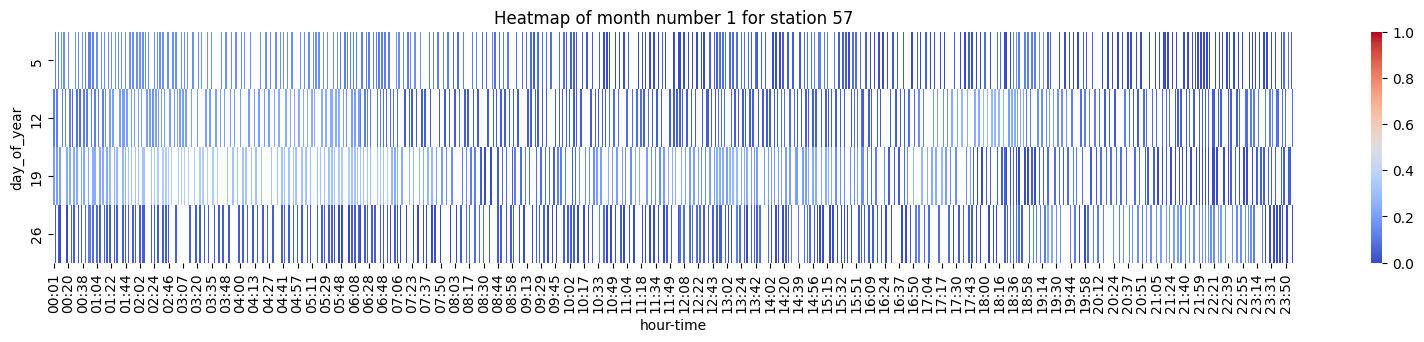

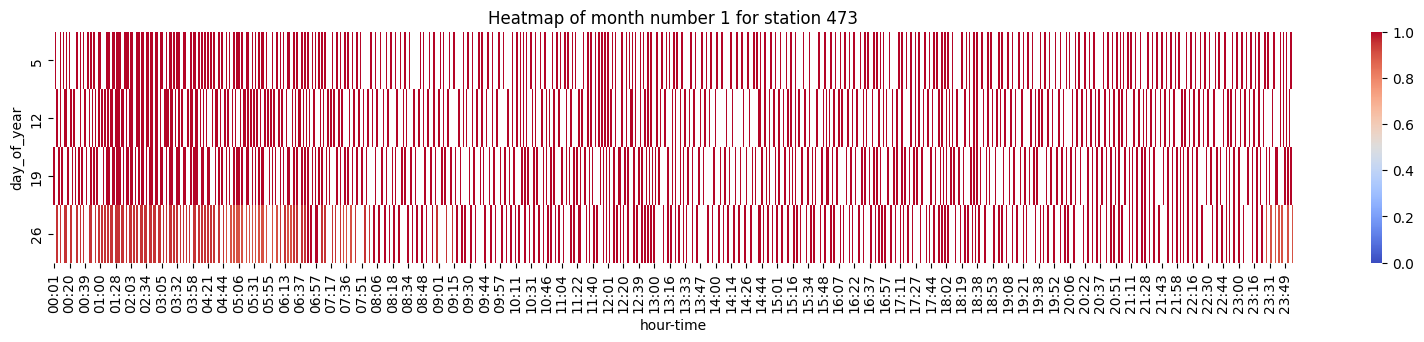

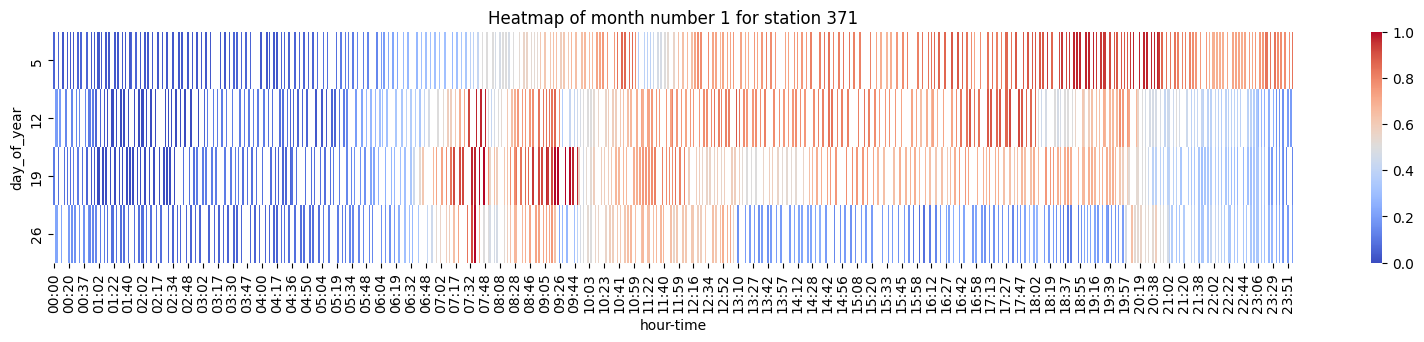

Weeks within the month are: <IntegerArray>
[52, 1, 2, 3, 4, 5]
Length: 6, dtype: UInt32
Choose one of the weeks: 3
You have chosen week 3.

Station is 57, classified as full with:
Capacity of 25
Altitude of 4.0

Station is 473, classified as empty with:
Capacity of 20
Altitude of 94.0

Station is 371, classified as other with:
Capacity of 36
Altitude of 19.0



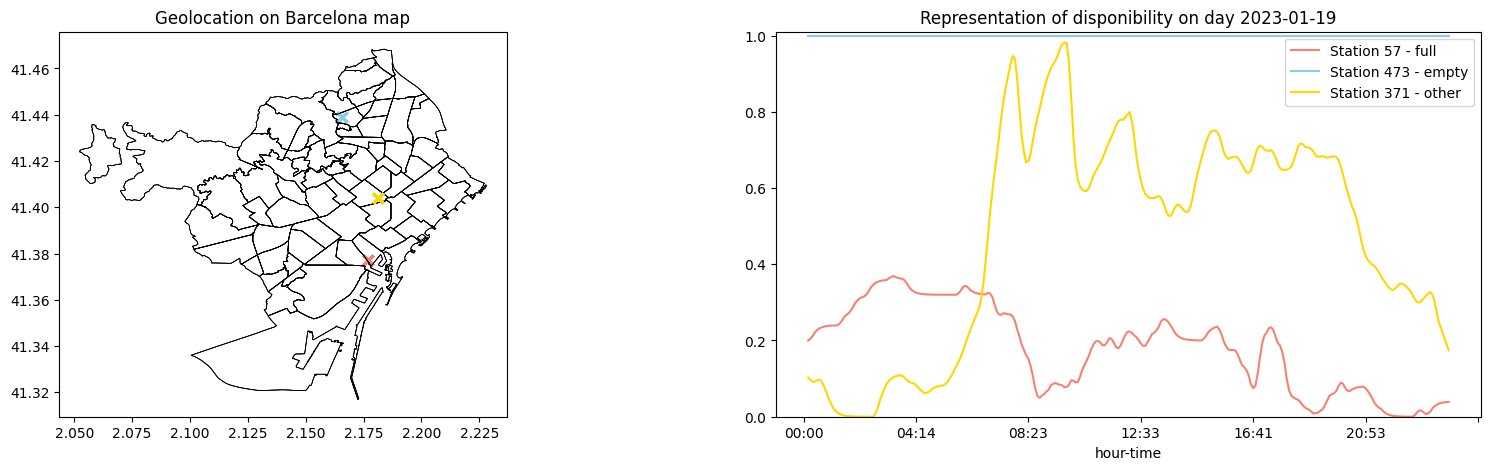

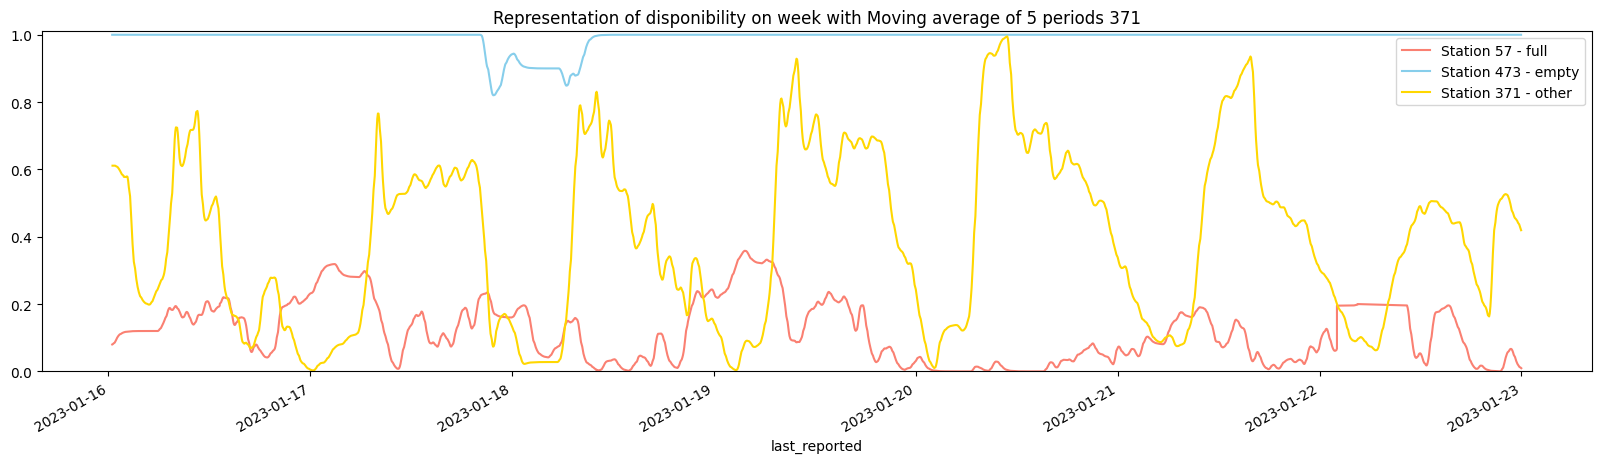

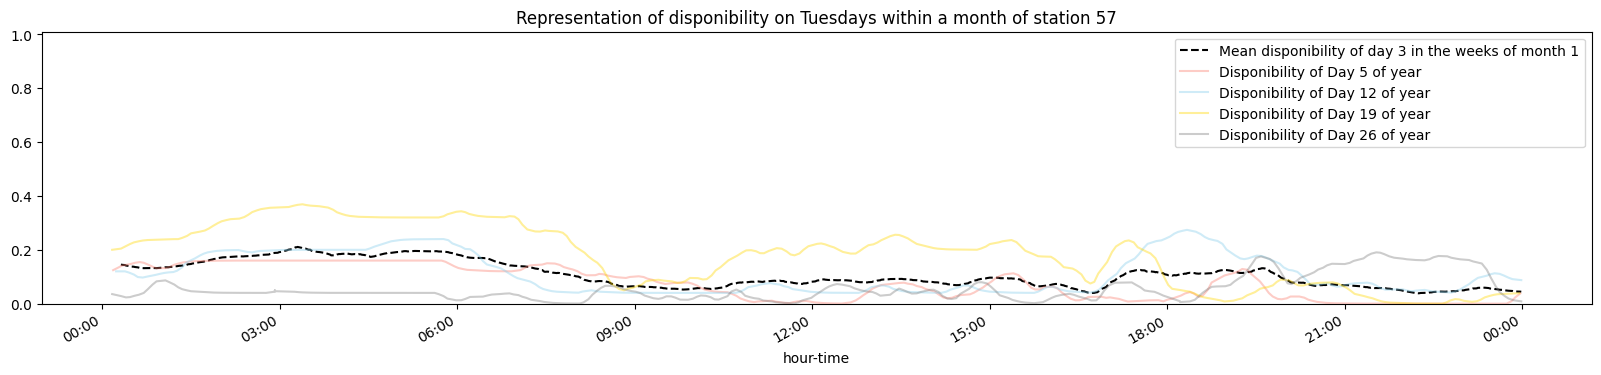

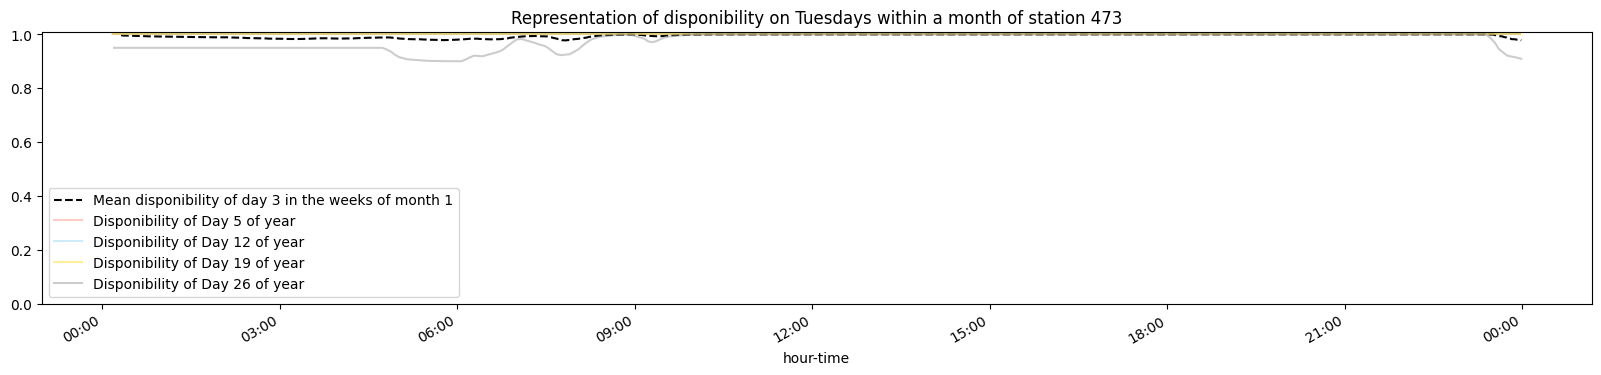

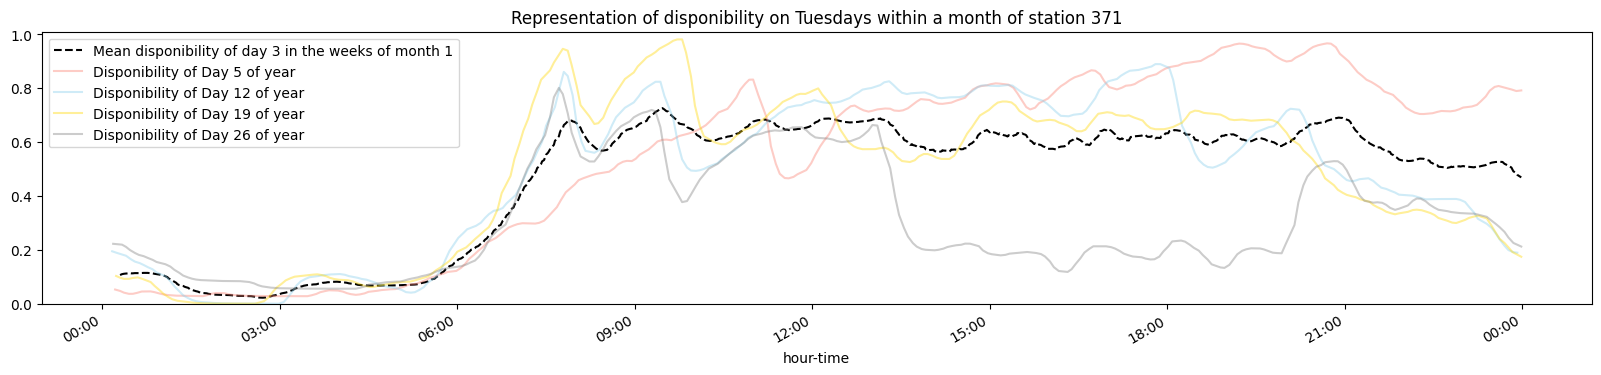

Visualitzating Month 2 of the year


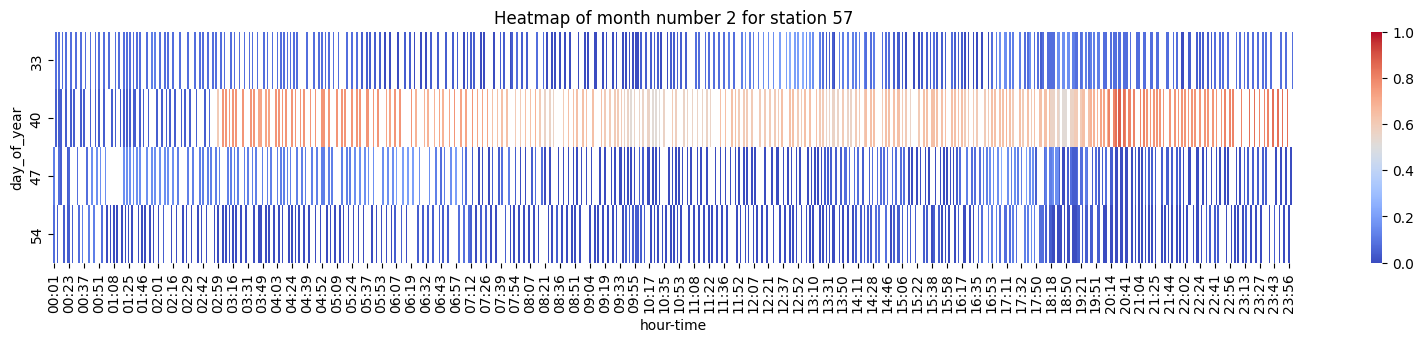

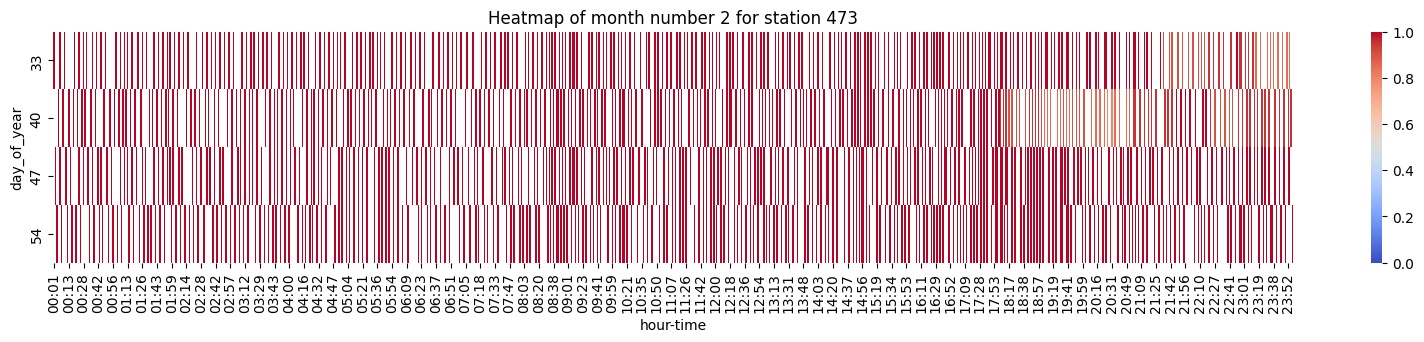

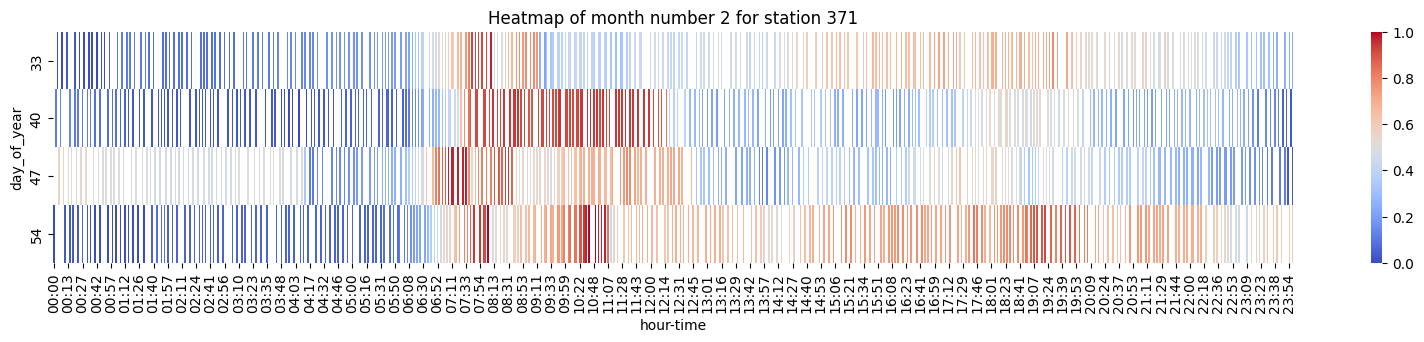

Weeks within the month are: <IntegerArray>
[9, 5, 6, 7, 8]
Length: 5, dtype: UInt32
Choose one of the weeks: 6
You have chosen week 6.

Station is 57, classified as full with:
Capacity of 25
Altitude of 4.0

Station is 473, classified as empty with:
Capacity of 20
Altitude of 94.0

Station is 371, classified as other with:
Capacity of 36
Altitude of 19.0



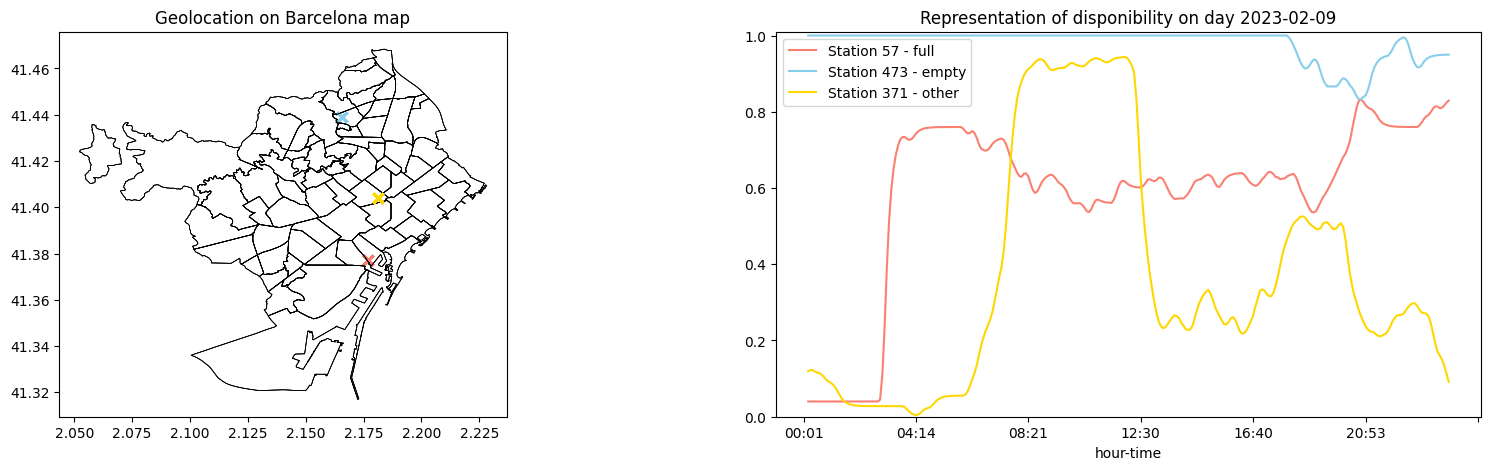

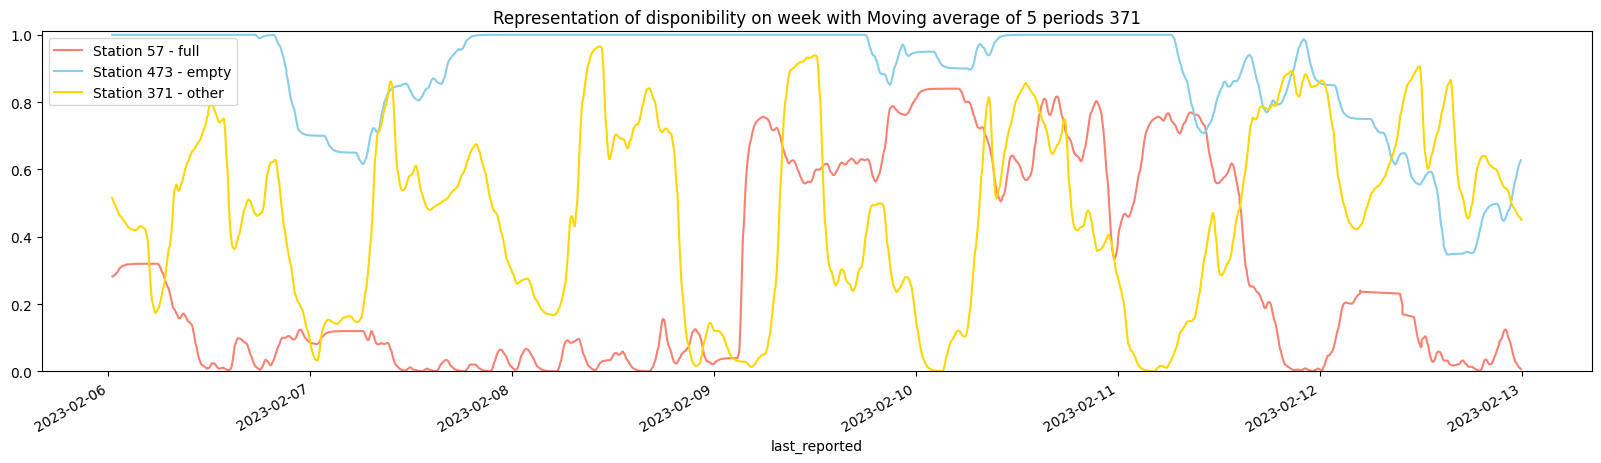

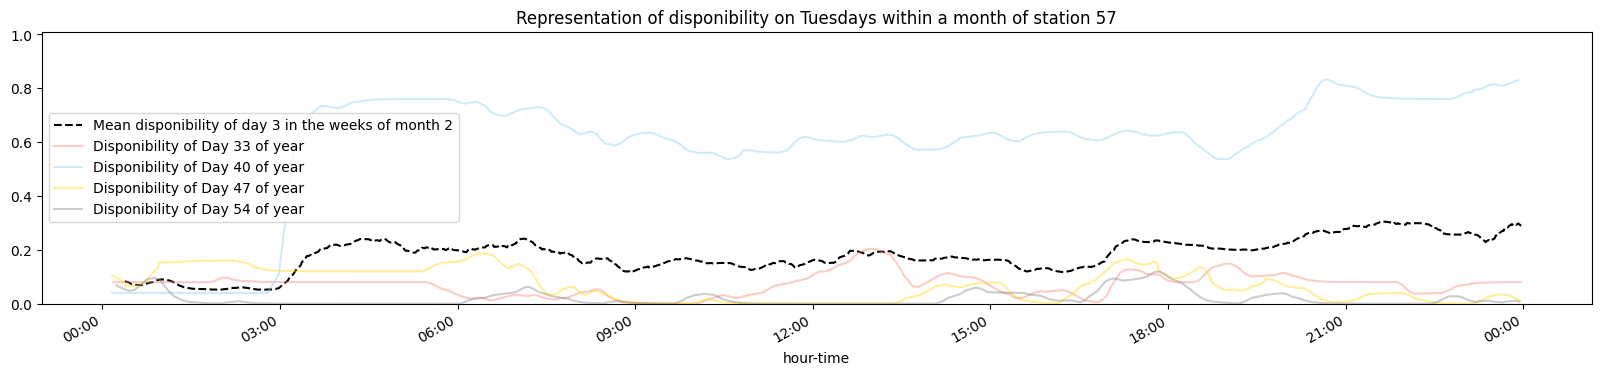

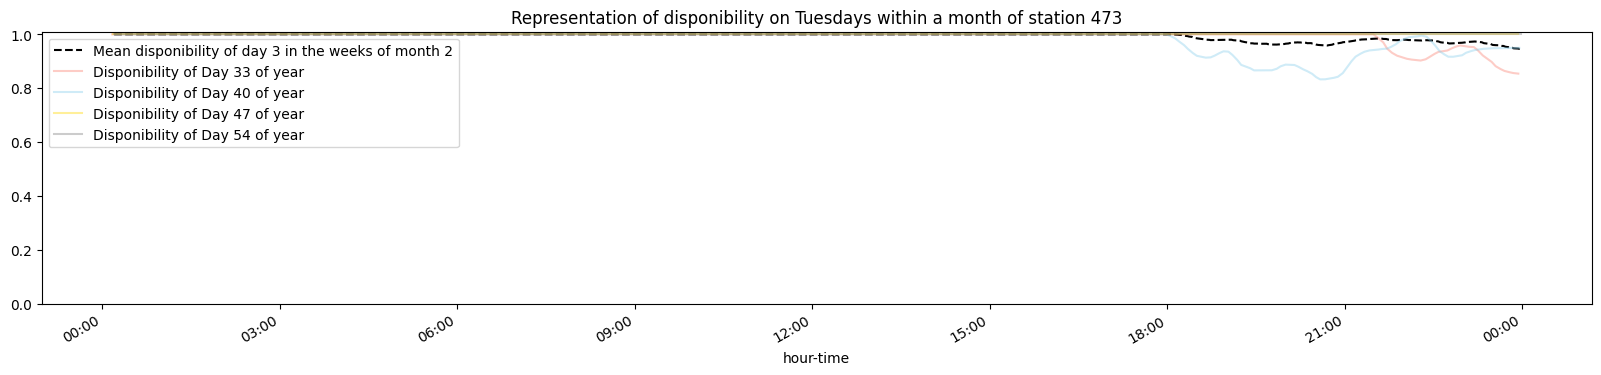

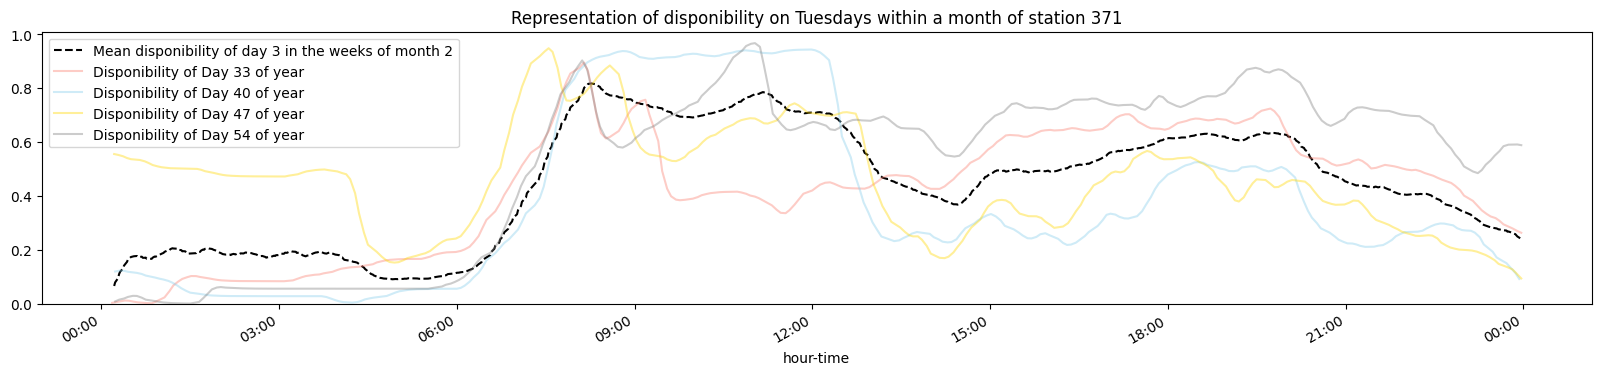

Visualitzating Month 3 of the year


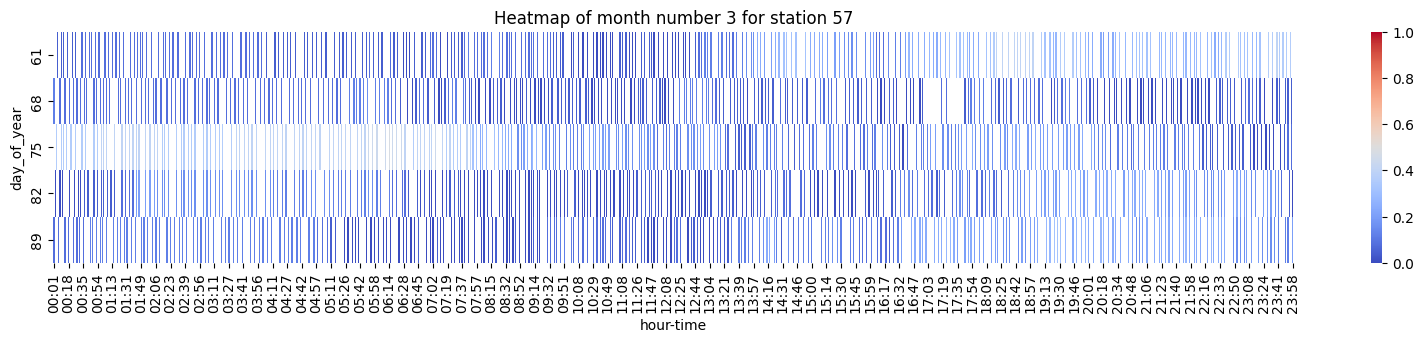

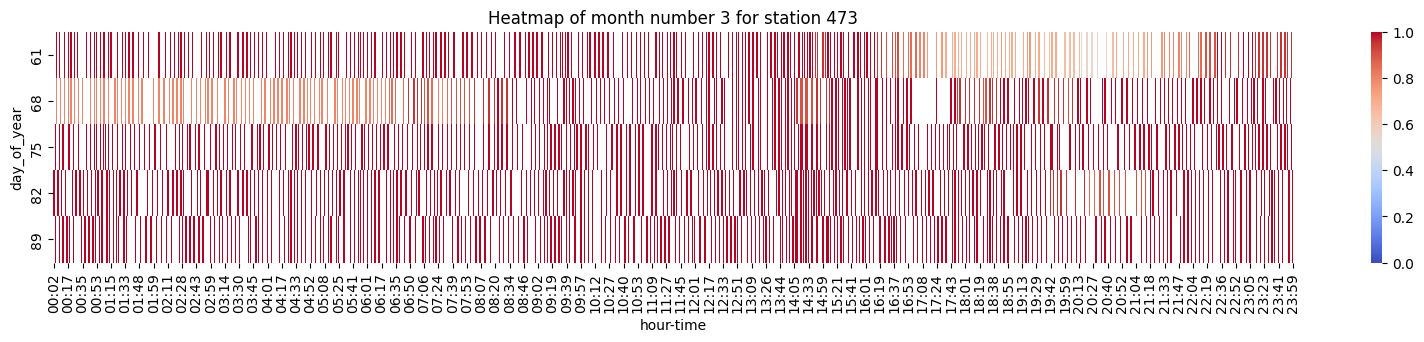

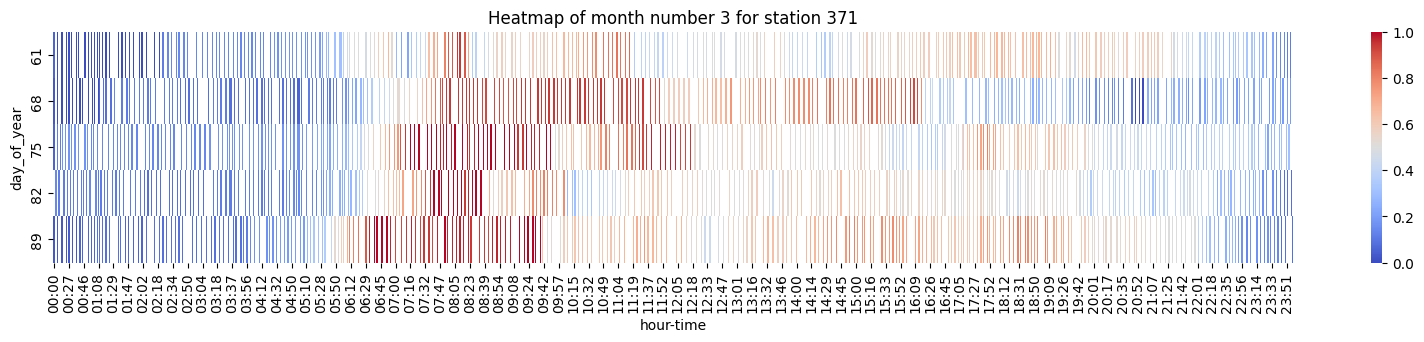

Weeks within the month are: <IntegerArray>
[9, 10, 11, 12, 13]
Length: 5, dtype: UInt32
Choose one of the weeks: 11
You have chosen week 11.

Station is 57, classified as full with:
Capacity of 25
Altitude of 4.0

Station is 473, classified as empty with:
Capacity of 20
Altitude of 94.0

Station is 371, classified as other with:
Capacity of 36
Altitude of 19.0



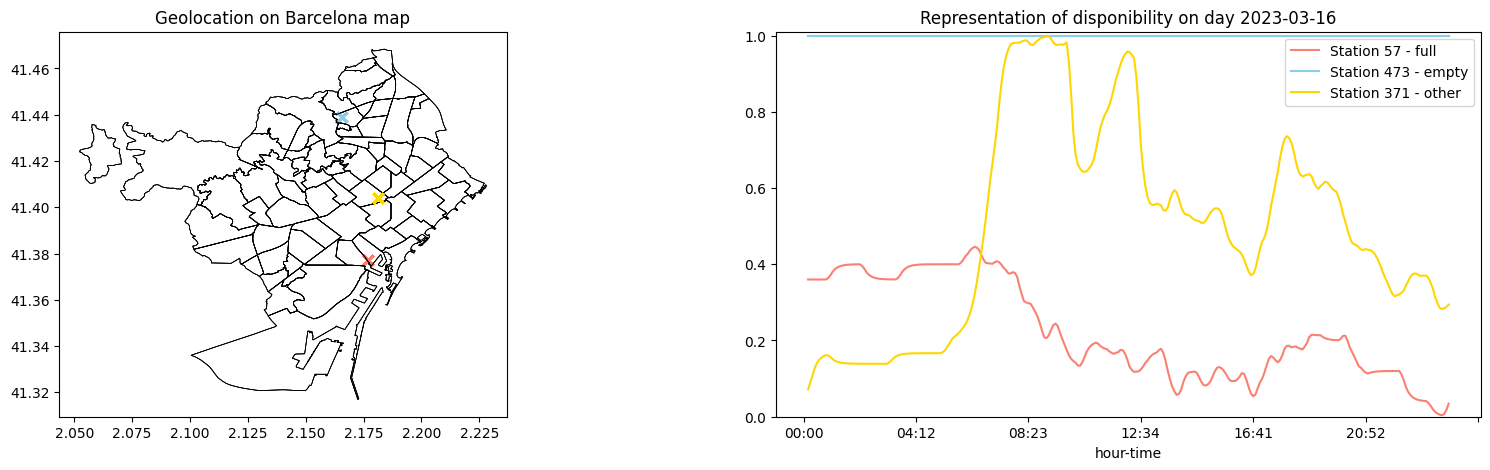

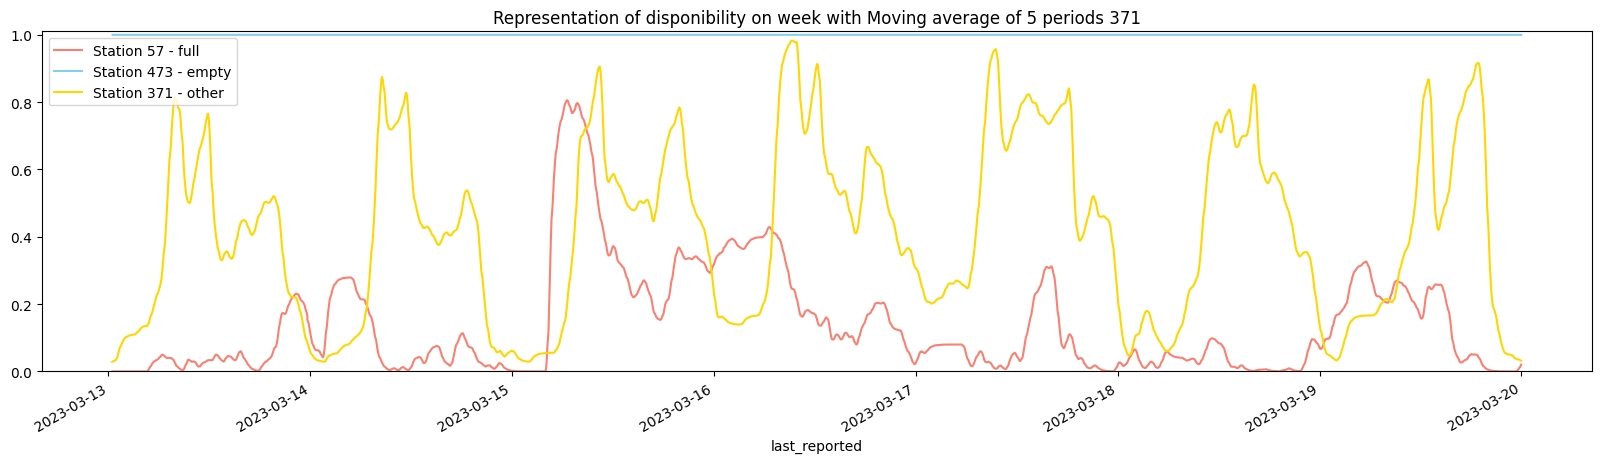

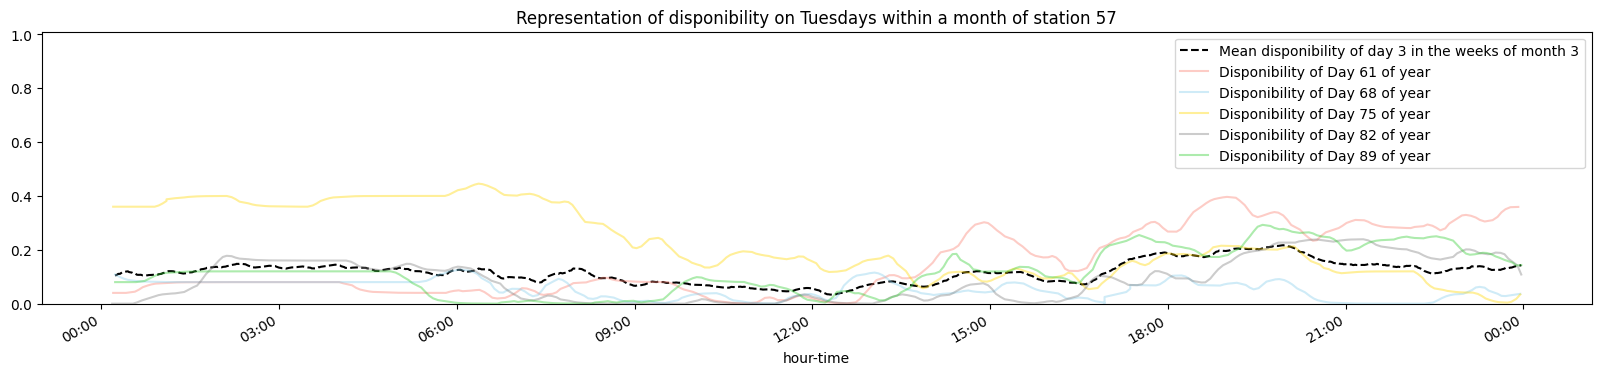

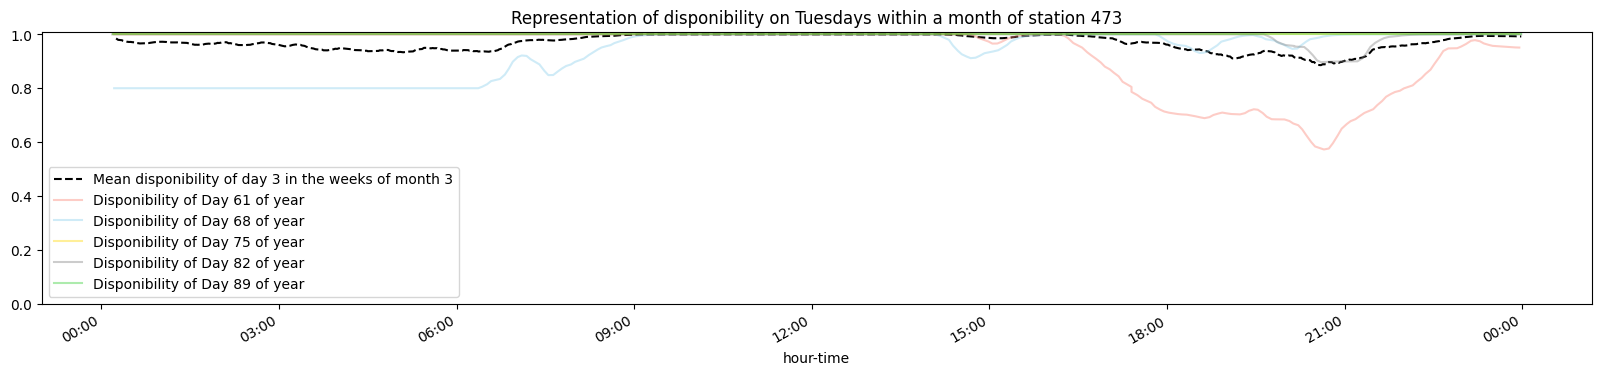

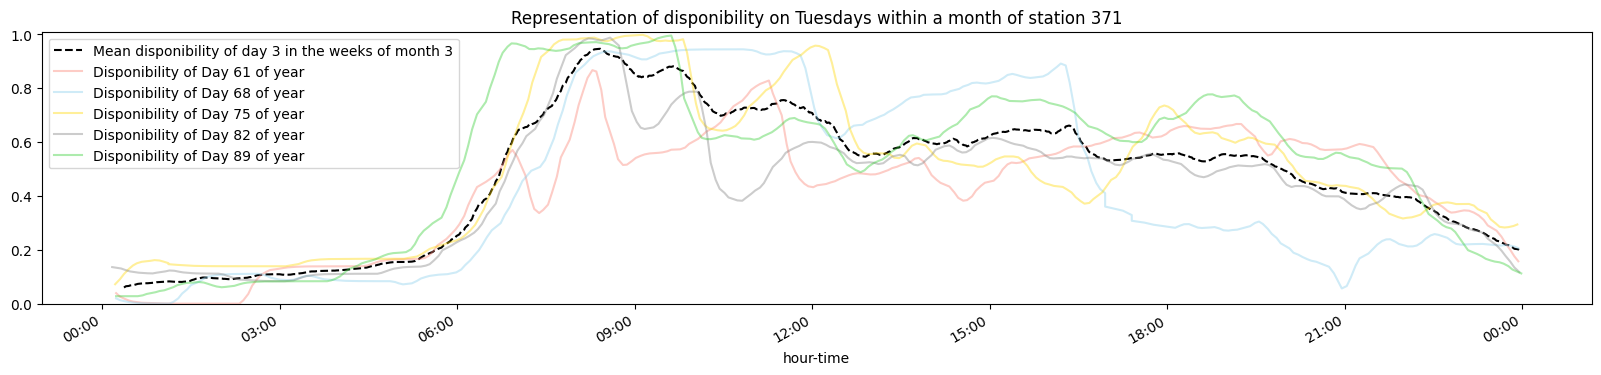

In [ ]:
# Visualitzation of March, and week number 10, day of week 3, which is thursday
ids = [57, 473, 371]
occus = ['full', 'empty', 'other']
day_of_week = 3
months = [1,2,3]

for n_month in months:
    print(f'Visualitzating Month {n_month} of the year')
    visual = Visualitzation(df_processed,
                            stations_info,
                            barris_geo,
                            n_month_of_year=n_month,
                            station_ids=ids,
                            occu_type=occus,
                            day_of_week=day_of_week)

    # Visualitzation of Heatmap in selcted month
    visual.heatmap()
    # Visualitzation occupancy changes in different stations with different patterns n one day of year (n_month_of_year, n_week_of_year, day_of_week)
    visual.plot_occupancy_stats()
    # Visualitzation of disponibility by hours in the same day of week within a month, visualized with different stations and mean of the days visualitzed
    visual.plot_disponibility_by_day()